<a href="https://colab.research.google.com/github/Ikshwaku-Tiwari/Eidolon/blob/main/Oracle_CVNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🌀 Generating 2000 snapshots of Larmor Precession...


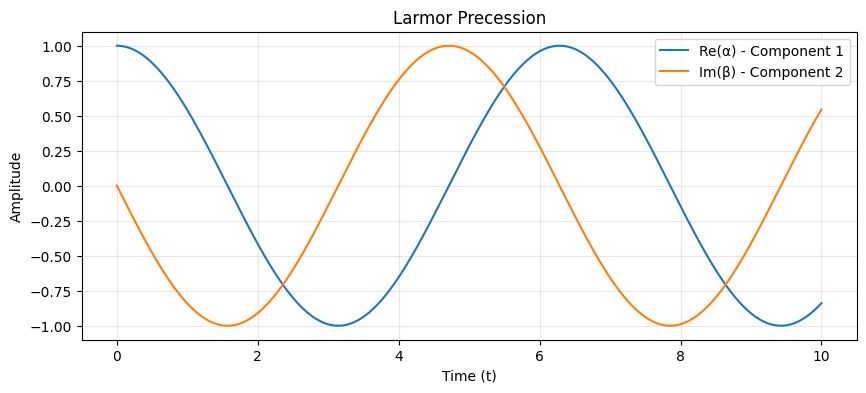

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def generate_larmor_data(samples=2000, t_max=10):
  print(f"🌀 Generating {samples} snapshots of Larmor Precession...")
  t = np.linspace(0, t_max, samples)
  omega = 2.0

  alpha = np.cos(omega * t / 2)
  beta = -1j * np.sin(omega * t / 2)

  y_real = np.stack([alpha.real, alpha.imag, beta.real, beta.imag], axis=1).astype(np.float32)
  y_complex = np.stack([alpha, beta], axis=1).astype(np.complex64)
  X = t.reshape(-1, 1).astype(np.float32)

  return X, y_real, y_complex

X, y_real, y_complex = generate_larmor_data()

plt.figure(figsize=(10, 4))
plt.plot(X, y_real[:, 0], label="Re(α) - Component 1")
plt.plot(X, y_real[:, 3], label="Im(β) - Component 2")
plt.title("Larmor Precession")
plt.xlabel("Time (t)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_real, test_size=0.2)

X_train_t = torch.tensor(X_train)
y_train_t = torch.tensor(y_train)
X_test_t = torch.tensor(X_test)
y_test_t = torch.tensor(y_test)

class BaselineOracle(nn.Module):
    def __init__(self):
        super(BaselineOracle, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 4)
        )

    def forward(self, x):
        return self.net(x)

model = BaselineOracle()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

print("🎓 Training the Baseline Oracle...")
for epoch in range(1001):
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, MSE Loss: {loss.item():.6f}")

print("✅ Baseline Training Complete.")

🎓 Training the Baseline Oracle...
Epoch 0, MSE Loss: 0.746799
Epoch 100, MSE Loss: 0.120983
Epoch 200, MSE Loss: 0.013423
Epoch 300, MSE Loss: 0.004961
Epoch 400, MSE Loss: 0.003819
Epoch 500, MSE Loss: 0.003161
Epoch 600, MSE Loss: 0.002377
Epoch 700, MSE Loss: 0.002248
Epoch 800, MSE Loss: 0.001751
Epoch 900, MSE Loss: 0.002148
Epoch 1000, MSE Loss: 0.001399
✅ Baseline Training Complete.


In [3]:
import torch
import torch.nn as nn
import numpy as np

class ComplexLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        scale = np.sqrt(1.0 / (in_features + out_features))

        self.re_weight = nn.Parameter(torch.randn(out_features, in_features) * scale)
        self.im_weight = nn.Parameter(torch.randn(out_features, in_features) * scale)
        self.re_bias = nn.Parameter(torch.zeros(out_features))
        self.im_bias = nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
        re_part = torch.matmul(x.real, self.re_weight.t()) - torch.matmul(x.imag, self.im_weight.t()) + self.re_bias
        im_part = torch.matmul(x.real, self.im_weight.t()) + torch.matmul(x.imag, self.re_weight.t()) + self.im_bias
        return torch.complex(re_part, im_part)

def complex_crelu(z):
    return torch.complex(torch.relu(z.real), torch.relu(z.imag))

class PyTorchComplexOracle(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = ComplexLinear(1, 64)
        self.fc2 = ComplexLinear(64, 64)
        self.fc3 = ComplexLinear(64, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = complex_crelu(x)
        x = self.fc2(x)
        x = complex_crelu(x)
        output = self.fc3(x)

        magnitude = torch.sqrt(torch.sum(torch.abs(output)**2, dim=1, keepdim=True) + 1e-8)
        normalized_output = output / magnitude

        return normalized_output

model_cvnn = PyTorchComplexOracle()
optimizer = torch.optim.Adam(model_cvnn.parameters(), lr=0.005)

X_complex_t = torch.complex(torch.tensor(X).float(), torch.zeros_like(torch.tensor(X).float()))
y_complex_t = torch.tensor(y_complex).to(torch.complex64)

print("🌀 Training the Corrected PyTorch Complex Oracle...")
for epoch in range(1001):
    optimizer.zero_grad()
    preds = model_cvnn(X_complex_t)
    loss = torch.mean(torch.abs(preds - y_complex_t)**2)

    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch:4d} | Complex Loss: {loss.item():.8f}")

print("✅ Training Complete. Run the Comparison Plot to see the Fidelity leap!")

🌀 Training the Corrected PyTorch Complex Oracle...
Epoch    0 | Complex Loss: 0.94111228
Epoch  200 | Complex Loss: 0.05681990
Epoch  400 | Complex Loss: 0.00619626
Epoch  600 | Complex Loss: 0.00077971
Epoch  800 | Complex Loss: 0.00032577
Epoch 1000 | Complex Loss: 0.00027824
✅ Training Complete. Run the Comparison Plot to see the Fidelity leap!


In [4]:
import numpy as np

def calculate_fidelity(y_true, y_pred):
    dot_product = np.sum(np.conj(y_true) * y_pred, axis=1)
    return np.abs(dot_product)**2

y_pred_base_raw = model(torch.tensor(X).float()).detach().numpy()
y_pred_base_comp = np.stack([
    y_pred_base_raw[:, 0] + 1j*y_pred_base_raw[:, 1],
    y_pred_base_raw[:, 2] + 1j*y_pred_base_raw[:, 3]
], axis=1)

y_pred_cvnn_comp = model_cvnn(X_complex_t).detach().numpy()

fid_baseline_scores = calculate_fidelity(y_complex, y_pred_base_comp)
fid_cvnn_scores = calculate_fidelity(y_complex, y_pred_cvnn_comp)

fid_baseline = np.mean(fid_baseline_scores)
fid_cvnn = np.mean(fid_cvnn_scores)

print(f"📊 FINAL RESEARCH RESULTS:")
print(f"   Baseline RVNN Fidelity: {fid_baseline:.6f}")
print(f"   PyTorch CVNN Fidelity:  {fid_cvnn:.6f}")

if fid_cvnn > fid_baseline:
    print("\n🚀 SUCCESS: The Complex-Valued Oracle is more physically accurate!")
else:
    print("\n💡 Insight: The models are performing similarly for this simple rotation.")

📊 FINAL RESEARCH RESULTS:
   Baseline RVNN Fidelity: 0.981958
   PyTorch CVNN Fidelity:  0.999089

🚀 SUCCESS: The Complex-Valued Oracle is more physically accurate!


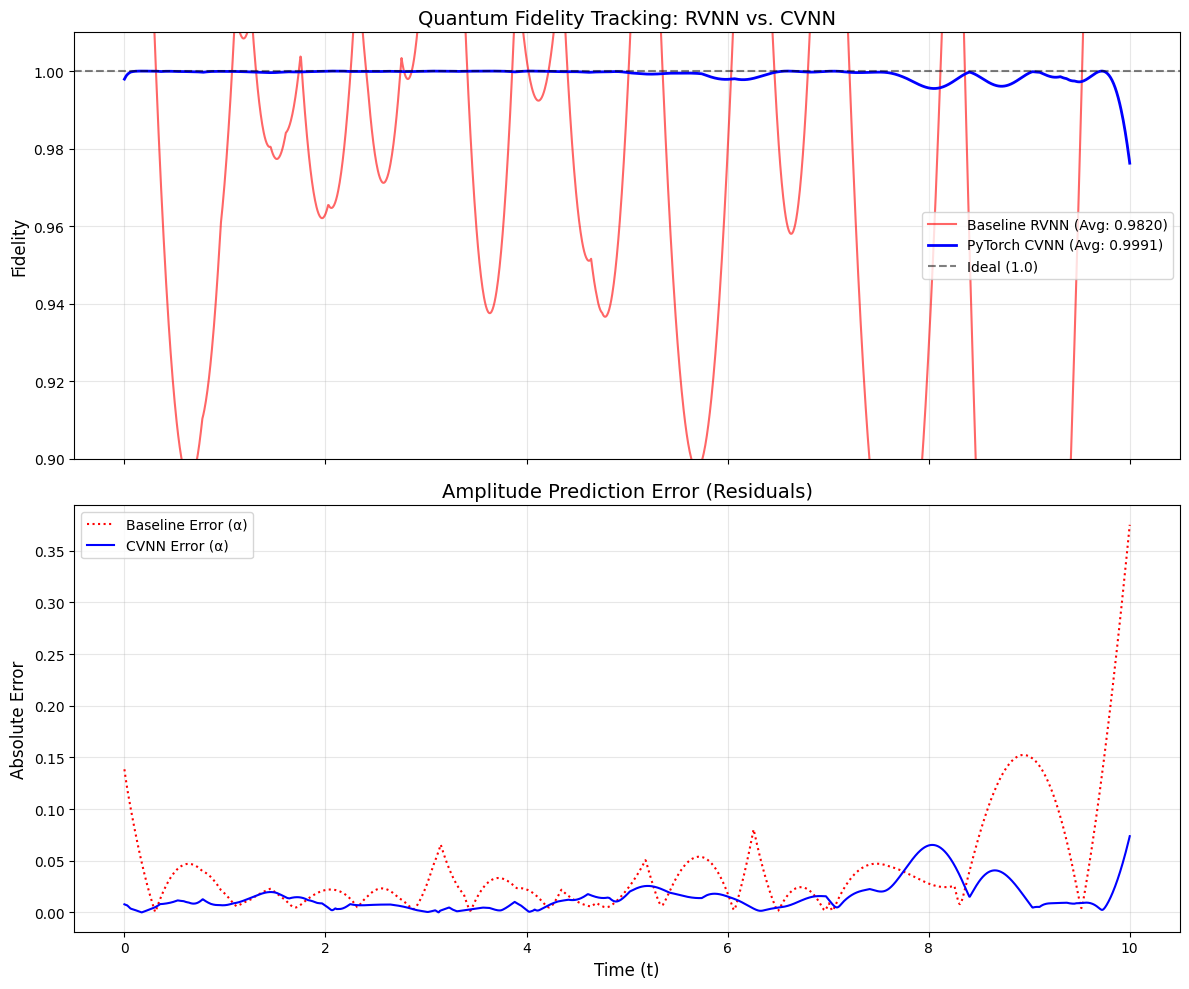

In [5]:
import matplotlib.pyplot as plt

with torch.no_grad():
    y_pred_cvnn = model_cvnn(X_complex_t).numpy()
    y_pred_base_raw = model(torch.tensor(X).float()).numpy()
    y_pred_base = np.stack([
        y_pred_base_raw[:, 0] + 1j*y_pred_base_raw[:, 1],
        y_pred_base_raw[:, 2] + 1j*y_pred_base_raw[:, 3]
    ], axis=1)

def get_fidelity_series(y_true, y_pred):
    dot = np.sum(np.conj(y_true) * y_pred, axis=1)
    return np.abs(dot)**2

fid_base_series = get_fidelity_series(y_complex, y_pred_base)
fid_cvnn_series = get_fidelity_series(y_complex, y_pred_cvnn)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

ax1.plot(X, fid_base_series, label=f"Baseline RVNN (Avg: {np.mean(fid_base_series):.4f})", color='red', alpha=0.6)
ax1.plot(X, fid_cvnn_series, label=f"PyTorch CVNN (Avg: {np.mean(fid_cvnn_series):.4f})", color='blue', linewidth=2)
ax1.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label="Ideal (1.0)")
ax1.set_title("Quantum Fidelity Tracking: RVNN vs. CVNN", fontsize=14)
ax1.set_ylabel("Fidelity", fontsize=12)
ax1.set_ylim(0.9, 1.01)
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(X, np.abs(y_complex[:, 0] - y_pred_base[:, 0]), color='red', linestyle=':', label="Baseline Error (α)")
ax2.plot(X, np.abs(y_complex[:, 0] - y_pred_cvnn[:, 0]), color='blue', label="CVNN Error (α)")
ax2.set_title("Amplitude Prediction Error (Residuals)", fontsize=14)
ax2.set_ylabel("Absolute Error", fontsize=12)
ax2.set_xlabel("Time (t)", fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()